https://github.com/AmritK10/MNIST-CNN/tree/master
Need to find already low res MNIST digits https://github.com/zatserkl/mnist_resolution/tree/master
 or we need to do pooling (max pooling)


In [70]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from sklearn.utils import resample
import matplotlib.pyplot as plt

In [71]:
# Load the MNIST dataset
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

In [72]:
# Print dimensions of the original images
print("Original Train Images Shape:", train_images.shape)
print("Original Test Images Shape:", test_images.shape)

Original Train Images Shape: (60000, 28, 28)
Original Test Images Shape: (10000, 28, 28)


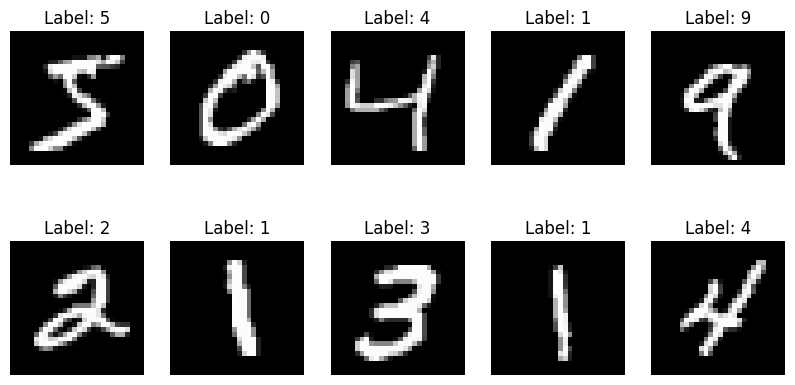

In [73]:
# Display some original images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

In [74]:
# Reshape images to 4D tensors (height, width, channels)
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1)
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1)

# Define the pooling layer
pooling_layer = tf.keras.layers.MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='valid')

# Apply max pooling to the images
train_images_pooled = pooling_layer(train_images)
test_images_pooled = pooling_layer(test_images)

# Normalize pixel values to be between 0 and 1
train_images_pooled = train_images_pooled / 255.0
test_images_pooled = test_images_pooled / 255.0

print("Pooled Train Images Shape:", train_images_pooled.shape)

Pooled Train Images Shape: (60000, 7, 7, 1)


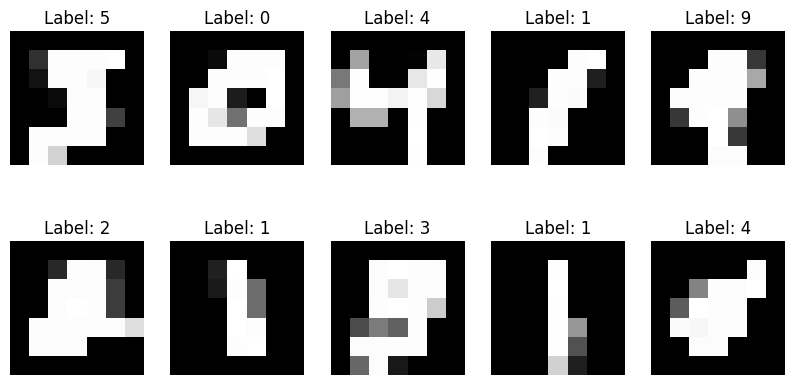

In [75]:
# Display some original images
plt.figure(figsize=(10, 5))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(train_images_pooled[i], cmap='gray')
    plt.title(f"Label: {train_labels[i]}")
    plt.axis('off')
plt.show()

In [76]:
# Reshape images to 3D tensors (height, width, channels)
train_images = train_images_pooled
test_images = test_images_pooled

In [77]:
# Define the CNN model with padding
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(7, 7, 1)),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Conv2D(64, (3, 3), padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])


/Users/alanzhang/Library/Python/3.10/lib/python/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


In [78]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
# Train the model
history = model.fit(train_images, train_labels, epochs=10, validation_data=(test_images, test_labels), verbose=2)

Epoch 1/10
1875/1875 - 6s - 3ms/step - accuracy: 0.8102 - loss: 0.5814 - val_accuracy: 0.8765 - val_loss: 0.3684
Epoch 2/10
1875/1875 - 5s - 3ms/step - accuracy: 0.8824 - loss: 0.3540 - val_accuracy: 0.8886 - val_loss: 0.3319
Epoch 3/10
1875/1875 - 5s - 3ms/step - accuracy: 0.8943 - loss: 0.3163 - val_accuracy: 0.9015 - val_loss: 0.3005
Epoch 4/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9017 - loss: 0.2963 - val_accuracy: 0.8994 - val_loss: 0.3001
Epoch 5/10
1875/1875 - 5s - 2ms/step - accuracy: 0.9044 - loss: 0.2834 - val_accuracy: 0.9023 - val_loss: 0.3013
Epoch 6/10
1875/1875 - 5s - 2ms/step - accuracy: 0.9090 - loss: 0.2721 - val_accuracy: 0.9042 - val_loss: 0.2985
Epoch 7/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9105 - loss: 0.2656 - val_accuracy: 0.9086 - val_loss: 0.2752
Epoch 8/10
1875/1875 - 5s - 2ms/step - accuracy: 0.9135 - loss: 0.2557 - val_accuracy: 0.9044 - val_loss: 0.2878
Epoch 9/10
1875/1875 - 5s - 3ms/step - accuracy: 0.9156 - loss: 0.2511 - val_accuracy: 0.9078 - 

In [65]:
# Evaluate model on test data
test_loss, test_acc = model.evaluate(test_images, test_labels, verbose=0)

In [66]:
# Mini-batch Bootstrap resampling for confidence interval estimation
n_iterations = 100
batch_size = 128  # Adjust batch size as needed
accuracy_results = []

for _ in range(n_iterations):
    # Randomly select indices for the mini-batch
    indices = np.random.choice(len(train_images), size=batch_size, replace=True)
    resampled_images, resampled_labels = train_images[indices], train_labels[indices]
    
    # Train model on resampled mini-batch
    model.fit(resampled_images, resampled_labels, epochs=10, verbose=0)
    
    # Evaluate model on test data
    _, acc = model.evaluate(test_images, test_labels, verbose=0)
    accuracy_results.append(acc)  # Append accuracy value to the list

# Compute confidence intervals
alpha = 0.95
p = ((1.0-alpha)/2.0) * 100
lower_confidence = max(0.0, np.percentile(accuracy_results, p))
p = (alpha+((1.0-alpha)/2.0)) * 100
upper_confidence = min(1.0, np.percentile(accuracy_results, p))

print(f'95% Confidence interval for accuracy: [{lower_confidence}, {upper_confidence}]')


TypeError: Only integers, slices (`:`), ellipsis (`...`), tf.newaxis (`None`) and scalar tf.int32/tf.int64 tensors are valid indices, got array([ 4196, 11304, 39907, 26030, 16827, 11484,  2914, 47330, 15437,
        2586,  2493, 39915, 43657, 15401, 31887, 12278,  8495, 13019,
       44844, 27018, 41040, 18570, 42655, 38049, 36126, 24938,  7279,
       39301, 40105, 25526, 53209, 54215, 20752, 27074, 27384, 46794,
       44573, 20582, 16170, 26124, 36462, 35401, 36241, 19812, 24692,
       23421, 53898, 49539, 46729, 44598, 59369, 58174, 44759, 59420,
       52866,  1804, 26823, 53988, 17399, 30503, 54802, 37121, 19443,
       56821, 50919, 51954,  4844, 34557, 22583,  8637, 14565, 31580,
       17106, 14738,   278, 22696, 36861, 53751, 30303, 17382, 51353,
       39998, 40682, 35637,  9525, 23955, 17228, 11543, 31320,  1162,
       46875, 26210, 59351, 57756, 12919,  1255, 12099, 38917, 10413,
       46387, 50737, 47645,  8167, 59825, 37077, 46987, 39275, 32255,
       19452, 43662, 27570, 56821, 41690, 43607,  6437, 57802, 45682,
       42272, 30716, 13458, 59320, 15306, 52757, 13851, 29056, 12209,
       48081, 17205])